In [7]:
# Code from "Deep MNIST for Experts" tensorflow tutorial

from __future__ import print_function

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import tensorflow as tf

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# Input layer
x  = tf.placeholder(tf.float32, [None, 784], name='x')
y_ = tf.placeholder(tf.float32, [None, 10],  name='y_')
x_image = tf.reshape(x, [-1, 28, 28, 1])

# Convolutional layer 1
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# Convolutional layer 2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# Fully connected layer 1
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# Dropout
keep_prob  = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# Fully connected layer 2 (Output layer)
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2, name='y')

# Evaluation functions
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')

# Training algorithm
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Training steps
sess = tf.Session()
sess.run(tf.initialize_all_variables())
max_steps = 1000
for step in range(max_steps):
    batch_xs, batch_ys = mnist.train.next_batch(50)
    if (step % 100) == 0:
        print(step, sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys, keep_prob: 0.5})
print(max_steps, sess.run(accuracy, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0 0.0698
100 0.863
200 0.9099
300 0.9291
400 0.9409
500 0.9445
600 0.955
700 0.9571
800 0.9598
900 0.9629
1000 0.962


The goal is to add noise to images of twos such that they still appear as twos to the human eye but are missclassified as sixes by the model. Therefore we'll need to isolate the twos data. Furthermore we will need these twos to be classified as sixes so that we can harvest the gradients for this missclassification.

In [22]:
# Get twos labels as sixes data
two_images = []
two_labels = []
six_labels = []
six_label = [0.0] * 10
six_label[6] = 1.0
for i in range(len(mnist.train.images)):
    if mnist.train.labels[i][2]==1.0:
        two_images.append(mnist.train.images[i])
        two_labels.append(mnist.train.labels[i])
        six_labels.append(six_label)

Now that we have the desired data we next need a way to get the derivative of the error with respect to the pixels in our image. Tensorflow has a built-in for this.

In [23]:
# Get the gradient of the error with respect to the pixels
grad = tf.gradients(cross_entropy, [x])[0]

Now that we have a bunch of twos labelled as sixes and an easy way to get gradients we're ready to actually compute our gradients. This will give us an image that we can then add to our original images to produce adversarial images.

In [24]:
# Compute delta, the gradient image to be added
import numpy as np
delta = sess.run(grad, feed_dict={x: two_images, y_: six_labels, keep_prob: 1.0})
delta = np.mean(delta, axis=0)
print(delta)

[ 1.18478247e-05 -1.96023302e-05  8.35524770e-06 -4.14494525e-06
 -2.00623181e-05  1.08351533e-05 -4.46160675e-06 -3.41317491e-06
  3.13715173e-05 -2.40116133e-05  1.68744900e-05  3.90736705e-06
  1.39635322e-05  2.43292834e-05 -3.79082007e-06  4.36382288e-06
 -1.80395691e-05 -4.63045154e-07  1.68247479e-05  4.96274561e-06
 -6.42385112e-06  1.12268744e-05 -2.95540176e-05  1.42499448e-05
  1.47808896e-05  4.52385990e-07  2.55029863e-06 -3.68497876e-06
 -1.23171840e-05 -3.92333732e-06 -3.20376421e-05 -3.50429241e-06
 -3.08746166e-05 -2.68998301e-05 -1.79199233e-05  1.64402154e-05
 -3.26587069e-05  3.38586033e-05 -3.34161887e-05  4.46312406e-05
  8.15602561e-06  8.58777184e-06  6.98521671e-06 -6.72475835e-07
 -5.20235471e-06 -2.11445627e-06 -1.32405548e-05  8.85768713e-06
 -3.04131445e-05  3.92428228e-06 -1.03301418e-05 -7.71838586e-07
 -7.95422329e-06 -7.95421329e-06 -3.19123205e-06  3.78725526e-05
 -7.16909426e-06  5.82869598e-06  1.37802426e-05 -3.95305278e-06
 -4.17209194e-05  2.21620

We see that the gradients are tiny. We scale them up by referring to images of the scaled up gradient images added to the original images. Note that adversarial images still look like twos.

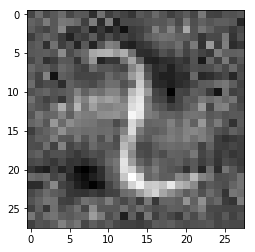

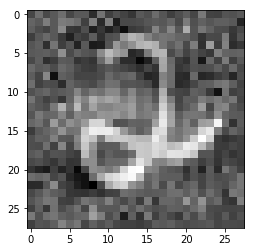

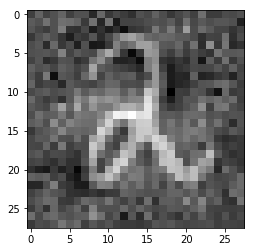

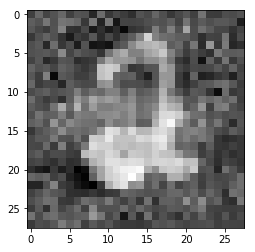

<Figure size 432x288 with 0 Axes>

In [34]:
import matplotlib.pyplot as plt
for i in range(4):
    plt.imshow(np.reshape(two_images[i] - 10000.0 * delta, (28,28)), cmap='gray')
    plt.figure()
plt.show()
delta *= 10000.0